# Reading the User config file for the pipeline

In [1]:
import sys
import numpy as np

# Read the pipeline config file to defines paths to code and data
token = open('/genesis/jwst/jwst-mtl-user/jwst-mtl_configpath.txt','r')
linestoken=token.readlines()
param,value = [],[]
for x in linestoken:
    tmp = x.replace(' ','') # but the '\n' will remain so rejects lines os len 1 and more
    if len(tmp) > 1:
        if (x[0] != '#'):
            line_parts = x.split('#')
            non_comments = x.split('#')[0].split()
            param_col = non_comments[0]
            value_col = non_comments[1]
            param.append(param_col)
            value.append(value_col)
token.close()
param = np.array(param)
value = np.array(value)
# User config file for paths
print('param and value for the user config file:')
print(param)
print(value)
print()

JWST_MTL_PATH = str(value[param == 'JWST-MTL_PATH'][0])
USER_PATH = str(value[param == 'USER_PATH'][0])
SIMULATION_PARAM = str(value[param =='SIMULATION_PARAM'][0])
FORTRAN_LIB = str(value[param == 'FORTRAN_LIB'][0])
MONOCHROMATIC_PSFS = str(value[param == 'MONOCHROMATIC_PSFS'][0])
PLANET_MODEL_ATM = str(value[param == 'PLANET_MODEL_ATM'][0])
SPECTRAL_CONV_KERNELS = str(value[param == 'SPECTRAL_CONV_KERNELS'][0])
STAR_MODEL_ATM = str(value[param == 'STAR_MODEL_ATM'][0])
TRACE_MODEL = str(value[param == 'TRACE_MODEL'][0])

# Include the path to code in the system path
#print(sys.path)
#print()
sys.path.insert(0, JWST_MTL_PATH+'/jwst-mtl/SOSS/trace/')
sys.path.insert(0, JWST_MTL_PATH+'/jwst-mtl/SOSS/specgen/')
sys.path.insert(0, FORTRAN_LIB)
sys.path.insert(0, USER_PATH)
#print(sys.path)


param and value for the user config file:
['JWST-MTL_PATH' 'USER_PATH' 'SIMULATION_PARAM' 'FORTRAN_LIB'
 'MONOCHROMATIC_PSFS' 'PLANET_MODEL_ATM' 'SPECTRAL_CONV_KERNELS'
 'STAR_MODEL_ATM' 'TRACE_MODEL' 'NOISE_FILES']
['/genesis/jwst/' '/genesis/jwst/jwst-mtl-user/'
 '/genesis/jwst/jwst-mtl-user/simpars_wide.txt'
 '/genesis/jwst/jwst-mtl-ref/fortran_lib/'
 '/genesis/jwst/jwst-mtl-ref/monochromatic_PSFs/'
 '/genesis/jwst/jwst-mtl-ref/planet_model_atm/'
 '/genesis/jwst/jwst-mtl-ref/spectral_conv_kernels/'
 '/genesis/jwst/jwst-mtl-ref/star_model_atm/'
 '/genesis/jwst/jwst-mtl-ref/trace_model/'
 '/genesis/jwst/jwst-mtl-ref/noise_files/']



# Python imports (needs to be done after config file read such that tracepol, for example, is seen in the system path) 

In [2]:


import os #checking status of requested files
#os.environ["OMP_NUM_THREADS"] = "24"

import numpy as np #numpy gives us better array management 

#Will be used to create FITS writer 
from astropy.io import fits #astropy modules for FITS IO

import matplotlib  #ploting
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import downscale_local_mean, resize

from tqdm.notebook import trange
from tqdm.notebook import tqdm as tqdm_notebook

import pyfftw
import multiprocessing as mp
#import scipy.signal
import scipy.fft
from matplotlib.colors import LogNorm
ncpu=mp.cpu_count()
pyfftw.config.NUM_THREADS = ncpu

#Trace Library
import tracepol as tp

#Top level simulation library
from write_dmsready_fits import write_dmsready_fits

#Used to monitor progress for multiprocessing pools
def barupdate(result):
    pbar.update()

## How to Compile Fortran libraries
in the utils folder run:  
  
`f2py3 -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lpthread -liomp5 --fcompiler=intelem --f90flags='-parallel -mkl -qopenmp' --f77flags='-parallel -mkl -qopenmp'`  
  
`f2py3 -c binmodels_py.pyf binmodels_py.f90 precision.f90 --fcompiler=intelem`  
  
move the .so files to your library import location (or current directory for your Jupyter notebook)

## Maestria Specific notes:

### Note: On maestria the intel compiler is not supported.  Please use gfortran instead:  
  
`f2py3 -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`
    
`f2py3 -c binmodels_py.pyf binmodels_py.f90 precision.f90`   
  
### skimage-

skimage package is not installed.  Local install needed:  
  
`pip3 install --user scikit-image`  



In [3]:
import spgen as spgen #Python Routines for SpecGen Routines and wrappers for fast-Transit-model.

## Notebook Parameters  
These parameters set up the work environment and readin model parameters

todo:  
- add rprstype to get planetmodel type

In [4]:
if False:
    # old definitions before Loic's reshuffle of 2020/09
    workdir='/home/loicalbert/Documents/python/gitdir/jwst-mtl/SOSS/' #root folder for local files
    workdir='/genesis/jwst/jwst-mtl/SOSS/'
    response_file=workdir+'tables/NIRISS_Throughput_STScI.fits'
    pmodeltype=2  ## Needs to be added as model parameter.  
    trace_file=workdir+'./trace/NIRISS_GR700_trace_extended.csv'
    model_dir = '/data/JWST/'
    star_model_dir = '/genesis/jwst/jwst-mtl-ref/star_model_atm/'
    planet_model_dir = '/genesis/jwst/jwst-mtl-ref/planet_model_atm/'
    kernel_dir = '/data/JWST/' #'/data/JWST/Kernel/Kernels1/' currently hard coded in /Kernel/Kernels1/ need changing
    kernel_dir = '/genesis/jwst/jwst-mtl-ref/monochromatic_PSFs/'

if True:
    # new definitions
    response_file = TRACE_MODEL+'NIRISS_Throughput_STScI.fits'
    trace_file = JWST_MTL_PATH+'/jwst-mtl/SOSS/trace/NIRISS_GR700_trace_extended.csv'
    star_model_dir = STAR_MODEL_ATM
    planet_model_dir = PLANET_MODEL_ATM
    kernel_dir = MONOCHROMATIC_PSFS
    simulation_param_file = SIMULATION_PARAM
    

pars=spgen.ModelPars()              #Set up default parameters
#simulation_param_file=workdir+'specgen/simpars_wide.txt'      #location of file for parameter import 
pars=spgen.read_pars(simulation_param_file,pars) #read in parameter file

pars.noversample=1 #example of changing a model parameter
pars.xout=2048
pars.yout=256

# List the orders to be simulated
# Current capability is 0 to 3 (June 26 2020)
order_list = np.array([1,2])
#order_list = np.array([0,1,2])

In [5]:
print(pars.pmodelfile[0])
print(pars.xcoo)
print(pars.ycoo)
print(pars.roll)

hd209458.csv
500.0
0.0
10.0


## Full Run to get 1-frame  
  
1) Get Instrument Response  
  
todo:  
- responce file should be a parameter

2) Read in Stellar Atmosphere  
  
todo: 
- ~~read in limb-darkening coefficients~~
- read in new Pheonix stellar models 

3) Read in Planet atmosphere 
  
todo:  
- add pmodeltype as model parameter  

4) Set up Trace 
  
todo:  
- set up as a default model parameter

5) Resample Spectra onto a common grid  

todo:  
- ~~common wavelength grid~~
- ~~bin starflux~~
- ~~bin planet r/R*~~
- ~~bin limb-darkening~~
- add interpolation when resolution is insufficient  
  
6) Transit Model  
  
todo:  
- ~~create solin array from pars.sol for each wavelength.~~
- ~~calculate transit-depth at each wavelength~~
- requires integration time
- time should be an array.
- add multiplanet capabilities  
  
7) Reading Kernels
  
todo:  
- resampling of Kernels is not ideal.  Needs thought.
  
8) Generate image with n=1,2,3 orders  
  
todo:
- ~~use resampled star,planet models~~
- ~~use transit model~~  
- scale total flux on detector using ETC output
- add orders -2,-1,0

In [6]:
print('Reading in Planet model')
planet_model_dir = '/genesis/jwst/jwst-mtl-ref/planet_model_atm/'
pmodeltype=2
planetmodel_wv,planetmodel_rprs=spgen.readplanetmodel(planet_model_dir+pars.pmodelfile[0],pmodeltype)

Reading in Planet model


In [7]:
# In the following bloc, the planet spectrum gj1214.txt can not be read. Have to handle that. Only hd209 works.

Reading in Response
Reading Stellar model


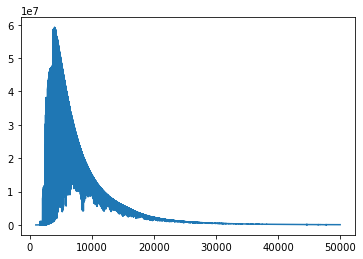

Reading in Planet model


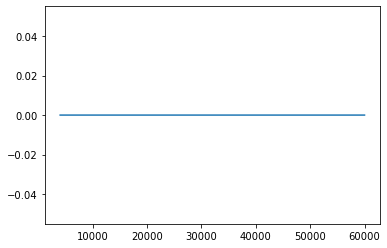

Setting up Trace


/genesis/jwst//jwst-mtl/SOSS/trace/tracepol.py:104: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)
/genesis/jwst//jwst-mtl/SOSS/trace/tracepol.py:104: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)


In [8]:
#1 Instrument response

print('Reading in Response')
#response_file = '/genesis/jwst/jwst-mtl-ref/trace_model/NIRISS_Throughput_STScI.fits'
response=spgen.readresponse(response_file)

#2 Stellar Atmosphere Model

print('Reading Stellar model')
starmodel_wv,starmodel_flux,ld_coeff=spgen.readstarmodel(star_model_dir+pars.modelfile,pars.nmodeltype)
plt.plot(starmodel_wv,starmodel_flux)
plt.show()

#3 Read in Planet atmosphere  

print('Reading in Planet model')
planetmodel_wv,planetmodel_rprs=spgen.readplanetmodel(planet_model_dir+pars.pmodelfile[0],pmodeltype)
# test removing the planet signature
planetmodel_rprs *= 0.0
plt.plot(planetmodel_wv,planetmodel_rprs)
plt.show()

#4 Set up Trace 

print('Setting up Trace')
tracePars = tp.get_tracepars(trace_file)


In [9]:
# in the following bloc, the kernel_dir is hard coded, need to be coded out.
# in fact, one should have to run (upstream) the WebbPSF code that will generate these kernels rather than rely on 
# a library of fits files.

In [10]:
#5 Resample star and planet models to common uniform in wavelength grid.

print('Resampling star and planet model')
#Get wavelength spacing to use for resampling
dw,dwflag=spgen.get_dw(starmodel_wv,planetmodel_wv,pars,tracePars)

#dw = dw/100

print("Wavelength spacing (A): ", dw,dwflag)
#Resample onto common grid.
bin_starmodel_wv,bin_starmodel_flux,bin_ld_coeff,bin_planetmodel_wv,bin_planetmodel_rprs=\
        spgen.resample_models(dw,starmodel_wv,starmodel_flux,ld_coeff,\
        planetmodel_wv,planetmodel_rprs,pars,tracePars)

# Make sure the array is sorted in increasing wavelengths
ind = np.argsort(bin_starmodel_wv)
bin_starmodel_wv = bin_starmodel_wv[ind]
bin_starmodel_flux = bin_starmodel_flux[ind]
bin_planetmodel_rprs = bin_planetmodel_rprs[ind]

#6 Transit model

print('Setting up Transit Model Parameters')
#This will become a routine
#Setup static Solution parameters (LD,r/R* and TED are wavelength dependent)
#This is a single planet example
solin=np.zeros(8+10*pars.nplanet) #TF5 style transit solution array
time=0.0    #time
itime=0.0001 #integration time (days)
solin[0]=np.copy(pars.sol[0]) #Mean stellar density
solin[8]=np.copy(pars.sol[1]) #EPO
solin[9]=np.copy(pars.sol[2]) #Period
solin[10]=np.copy(pars.sol[3]) #Impact parameter
solin[12]=np.copy(pars.sol[4]) #ECW
solin[13]=np.copy(pars.sol[5]) #ESW
solin[14]=np.copy(pars.sol[6]) #KRV
solin[16]=np.copy(pars.sol[7]) #ELL
solin[17]=np.copy(pars.sol[8]) #ALB 

#7 #Read in Kernels

print('Reading in and resampling PSF Kernel')
kernel_dir = '/genesis/jwst/jwst-mtl-ref/monochromatic_PSFs/'
kernels,kernels_wv=spgen.readkernels(kernel_dir)
#resize Kernels 
#limit oversampling to be: 1<10
kernel_resize=[]
for k in kernels:
    kernel_resize.append(resize(k,(128*pars.noversample,128*pars.noversample)))

Resampling star and planet model
Wavelength spacing (A):  0.9599941999986186 0
Setting up Transit Model Parameters
Reading in and resampling PSF Kernel


## Create Convolved Image

In [11]:
if True:


    # The number of images (slices) that will be simulated is equal the number of orders
    # Don't worry, that 'cube' will be merged down later after flux normalization.
    nslice = np.size(order_list)

    # Defines the dimensions of the arrays, depends on the oversanmpling
    xmax=pars.xout*pars.noversample
    ymax=pars.yout*pars.noversample
    # Note that we will generate a cube of those images, nslice is the number of orders
    convolved_image=np.zeros((nslice,ymax,xmax))


    for m in range(np.size(order_list)): 

        nth_order = order_list[m]
        print('Generating Order {:}'.format(nth_order))

        pixels=spgen.gen_unconv_image(pars,response,bin_starmodel_wv,bin_starmodel_flux,\
                    bin_ld_coeff,bin_planetmodel_rprs,time,itime,solin,nth_order,tracePars)

        pixels_t=np.copy(pixels.T)

        #Enable threads (not working?!?!)
        #pyfftw.config.NUM_THREADS = 1 #do not need multi-cpu for pools
        #with scipy.fft.set_backend(pyfftw.interfaces.scipy_fft):
        # Turn on the cache for optimum performance
        #pyfftw.interfaces.cache.enable()

        #do the convolution
        x=pixels_t*0+1.0e-10

        nwv=len(kernels_wv) #number of wavelengths to process
        pbar = tqdm_notebook(total=nwv)  #Will make a progressbar to monitor processing.  
        pool = mp.Pool(processes=ncpu)  #Use lots of threads - because we can! 

        results = [pool.apply_async(spgen.convolve_1wv,\
                                args=(pixels_t,kernel_resize,kernels_wv,wv_idx,pars,nth_order,tracePars,),\
                                callback=barupdate) for wv_idx in range(nwv)]

        pixels_c = [p.get() for p in results]

        pool.close()
        pool.join()

        #bring together the results
        x=pixels_t*0+1.0e-10
        for p in pixels_c:
            x+=p

        pixels_c=None #release Memory

        convolved_image[m,:,:] += x

        # Sum in the flux for that order
        actual_counts = np.sum(convolved_image[m,:,:])
        print('Actual counts measured on the simulation = {:} e-/sec'.format(actual_counts))
        print()


Generating Order 1


Actual counts measured on the simulation = 214934422.71132544 e-/sec

Generating Order 2



Actual counts measured on the simulation = 107553268.4044661 e-/sec



In [12]:
# Save the fits image on disk
hdu = fits.PrimaryHDU()
hdu.data = np.sum(convolved_image,axis=0)
hdu.writeto('toto.fits', overwrite=True)

# Flux Normalization Piece of Code

Counts below are in ADU/second.


/genesis/jwst//jwst-mtl/SOSS/trace/tracepol.py:104: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)
/genesis/jwst//jwst-mtl/SOSS/trace/tracepol.py:104: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)


Expected counts returned are:  [44977646.10165907 13251245.17606097]

Order 1: simulated counts = 214934422.71132544, expected counts = 44977646.101659074
The scale factor to apply is 0.20926218115405248

Order 2: simulated counts = 107553268.4044661, expected counts = 13251245.176060965
The scale factor to apply is 0.12320634577303756

Final check on the calibrated, merged down image:
Counts on final image = 58228891.27772004, Expected counts = 58228891.27772004
Start of write_dmsready_fits
/genesis/jwst/jwst-mtl-user/mysimulation_dmsready.fits was written with dimensions nint=1, ngroup=1, dimy=256, dimx=2048, subarray=SUBSTRIP256
write_dmsready_fits completed successfuly.


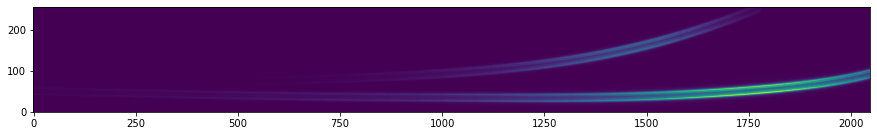

In [13]:
import synthesizeMagnitude as smag

if True:
    # At this point, the simulation consists in separate images for each order 
    # (stored in the 3rd dimension) and has oversampled dimensions.
    # It is: convolved_image[m,y,x] where m is the orders dimension.
    #

    # PART A - Definition of parameter values
    filtername = 'J' # See readFilter in synthesizeMagnitude.py to see the many supported filter names
    magnitude = 8.5 # In the Vega magnitude system for most filters, occasionaly in AB system
    model_um = bin_starmodel_wv/10000 # Need to have the input in micrometers
    model_flamba = bin_starmodel_flux # Needs to be Flambda, not Fnu
    return_adupersec = True # if False then it returns e- per sec
    fitsname = 'clear.fits'
    fitsname_f277 = 'f277.fits'
    if return_adupersec is True: print('Counts below are in ADU/second.')
    else: print('Counts below are in electrons/second.')


    # PART B - Calculate the expected number of counts per second (either electrons or adu)
    # based on the model spectrum and assumptions on the JWST surface area and electronic gain.
    expected_counts = smag.expected_flux_calibration(filtername,magnitude,model_um,
                                                     model_flamba, order_list,
                                                     convert_to_adupersec=return_adupersec,
                                                     verbose=False,
                                                     trace_file=trace_file,
                                                     response_file=response_file,
                                                     pathfilter='/genesis/jwst/jwst-mtl/SOSS/specgen/FilterSVO/',
                                                     pathvega='/genesis/jwst/jwst-mtl/SOSS/specgen/FilterSVO/')
    print('Expected counts returned are: ', expected_counts)
    print()

    # PART C - Apply the normlization and bin oversampled image to native pixel size
    # Initialize a cube that will be flux calibrated 
    normalized_cube = np.copy(convolved_image)
    # The scale factors needed for each order is stored in here
    scalefactors = np.copy(expected_counts) * 0.0
    simulated_counts = np.copy(expected_counts) * 0.0
    # Apply the normalization one order at a time
    for i in range(np.size(order_list)):
        simulated_counts[i] = np.sum(convolved_image[i,:,:])
        scalefactors[i] = expected_counts[i] / simulated_counts[i]
        print('Order {:}: simulated counts = {:}, expected counts = {:}'.format(
            order_list[i],simulated_counts[i],expected_counts[i]))
        print('The scale factor to apply is {:}'.format(scalefactors[i]))
        normalized_cube[i,:,:] = convolved_image[i,:,:] * scalefactors[i]
        print()
    # To bin down to the native pixel size and merge down the cube into a single image, use this function
    image_nativesize = downscale_local_mean(np.sum(normalized_cube,axis=0),(pars.noversample,pars.noversample))*pars.noversample**2
    native_counts = np.sum(image_nativesize)
    print('Final check on the calibrated, merged down image:')
    print('Counts on final image = {:}, Expected counts = {:}'.format(native_counts,np.sum(expected_counts)))


    # PART D - Orient the image for the DMS format and save it to disk
    # Here, image is still not in the DMS format. We need to make a flip vertically.
    image_nativesize_DMS = np.flip(image_nativesize,axis=0)
    # Save the fits image on disk
    hdu = fits.PrimaryHDU()
    hdu.data = image_nativesize_DMS
    hdu.writeto(fitsname, overwrite=True)
    # Display the image
    plt.figure(figsize=(15,8))
    plt.imshow(image_nativesize_DMS, origin='lower')
    
    # Save the image with proper headers and DMS ready
    flattened_image_oversampled = np.sum(normalized_cube,axis=0)
    write_dmsready_fits(flattened_image_oversampled, USER_PATH+'mysimulation_dmsready.fits',
                            os=pars.noversample, input_frame='sim')


    

In [14]:
if False:
    # These checks can be left out.

    # Check again that counts are ok
    native_counts = np.sum(image_nativesize)
    print('Counts on final image = {:}, Expected counts = {:}'.format(native_counts,np.sum(expected_counts)))

    # Check what is the brightest pixel. Does it make sense?
    CDS_integrationtime = 3*5.5 # seconds
    maxvalue = np.max(image_nativesize_DMS)*CDS_integrationtime
    print('Brightest pixel on a CDS is {:.0F} adu or e-'.format(maxvalue))

# Generate an F277W exposure.

## The usual flux calibration will not work for such an exposure because the model_flux is set to zero in most filters that one would like to calibrate with. Instead, use the calibration made for the CLEAR exposure and apply it to the F277W blindly, after having multiplied the model flux by the F277W absolute transmission.

(1e-100, 10000000000.0)

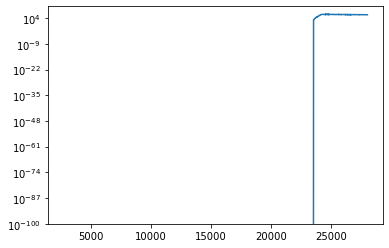

In [15]:
path_filters = '/genesis/jwst/jwst-mtl/SOSS/specgen/FilterSVO/'

F277_um, F277_T, F277_system = smag.readFilter('NIRISS.F277W',
                                               path_filter_transmission=path_filters,
                                               keepPeakAbsolute=True,returnWidth=False,
                                               verbose = False)
#plt.plot(F277_um,F277_T)
# Interpolate the filter curve to match the model wavelength coverage
# Convert wavelength to angstroms because those are the units used
# in generating simulations.
f277_transmission = np.interp(bin_starmodel_wv, F277_um*10000, F277_T)
#plt.plot(model_um,f277_transmission)
#plt.semilogy()
#plt.ylim((1e-100,1))
# The new model to create simulations for is the original times the filter transmission
bin_starmodel_flux_f277 = bin_starmodel_flux * f277_transmission

plt.plot(bin_starmodel_wv, bin_starmodel_flux_f277)
plt.semilogy()
plt.ylim((1e-100,1e+10))


## Create Convolved Image

## For F277W. Same as for CLEAR but the model is multiplied by the F277W absolute response in the call to spgen.gen_unconv_image() inside the loop.

In [16]:
# The number of images (slices) that will be simulated is equal the number of orders
# Don't worry, that 'cube' will be merged down later after flux normalization.
nslice = np.size(order_list)

# Defines the dimensions of the arrays, depends on the oversanmpling
xmax=pars.xout*pars.noversample
ymax=pars.yout*pars.noversample
# Note that we will generate a cube of those images, nslice is the number of orders
convolved_image_f277=np.zeros((nslice,ymax,xmax))

for m in range(np.size(order_list)):
#for m in range(1,0,-1):

    nth_order = order_list[m]
    print('Generating Order {:}'.format(nth_order))

    # bin_starmodel_flux_f277 is used instead of bin_starmodel_flux
    pixels=None
    pixels=spgen.gen_unconv_image(pars,response,bin_starmodel_wv,bin_starmodel_flux_f277,\
                bin_ld_coeff,bin_planetmodel_rprs,time,itime,solin,nth_order,tracePars)

    pixels_t=np.copy(pixels.T)
    if nth_order == 2:
        hdu = fits.PrimaryHDU()
        hdu.data = pixels_t
        hdu.writeto('debug_f277_order2_trace.fits', overwrite=True)        

    #Enable threads (not working?!?!)
    #pyfftw.config.NUM_THREADS = 1 #do not need multi-cpu for pools
    #with scipy.fft.set_backend(pyfftw.interfaces.scipy_fft):
    # Turn on the cache for optimum performance
    #pyfftw.interfaces.cache.enable()

    #do the convolution
    x=pixels_t*0+1.0e-10

    nwv=len(kernels_wv) #number of wavelengths to process
    pbar = tqdm_notebook(total=nwv)  #Will make a progressbar to monitor processing.  
    pool = mp.Pool(processes=ncpu)  #Use lots of threads - because we can! 

    results = [pool.apply_async(spgen.convolve_1wv,\
                            args=(pixels_t,kernel_resize,kernels_wv,wv_idx,pars,nth_order,tracePars,),\
                            callback=barupdate) for wv_idx in range(nwv)]

    pixels_c = [p.get() for p in results]

    pool.close()
    pool.join()

    #bring together the results
    x=pixels_t*0+1.0e-10
    for p in pixels_c:
        x+=p

    pixels_c=None #release Memory

    convolved_image_f277[m,:,:] += x
    
    # Sum in the flux for that order
    actual_counts = np.sum(convolved_image_f277[m,:,:])
    print('Actual total counts measured on the simulation = {:} e-/sec'.format(actual_counts))
    print()


Generating Order 1


Actual total counts measured on the simulation = 2862358.565214735 e-/sec

Generating Order 2


Actual total counts measured on the simulation = 5.242880000000003e-05 e-/sec



# Compute expected counts, bin to native size, convert to DMS coordinates and save on disk.

Counts below are in ADU/second.


/genesis/jwst//jwst-mtl/SOSS/trace/tracepol.py:104: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)
/genesis/jwst//jwst-mtl/SOSS/trace/tracepol.py:104: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)


Expected counts returned are:  [1219154.90733606       0.        ]

Order 1: simulated counts = 2862358.565214735, expected counts = 1219154.9073360572
The scale factor to apply is 0.4259266893225852

Order 2: simulated counts = 5.242880000000003e-05, expected counts = 0.0
The scale factor to apply is 0.0

Final check on the calibrated, merged down image:
Counts on final image = 1219154.9073360572, Expected counts = 1219154.9073360572


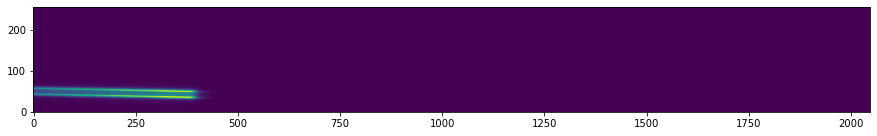

In [17]:
# PART A - Definition of parameter values
filtername = 'J' # See readFilter in synthesizeMagnitude.py to see the many supported filter names
magnitude = 8.5 # In the Vega magnitude system for most filters, occasionaly in AB system
model_um = bin_starmodel_wv/10000 # Need to have the input in micrometers
model_flamba = bin_starmodel_flux # Needs to be Flambda, not Fnu
return_adupersec = True # if False then it returns e- per sec
fitsname_f277 = 'f277.fits'
if return_adupersec is True: print('Counts below are in ADU/second.')
else: print('Counts below are in electrons/second.')


# PART B - Calculate the expected number of counts per second (either electrons or adu)
# based on the model spectrum and assumptions on the JWST surface area and electronic gain.
expected_counts_f277 = smag.expected_flux_calibration(filtername,magnitude,model_um,
                                                 model_flamba, order_list,
                                                 convert_to_adupersec=return_adupersec,
                                                 verbose=False, 
                                                 trace_file=trace_file,
                                                 response_file=response_file,
                                                 pathfilter='/genesis/jwst/jwst-mtl/SOSS/specgen/FilterSVO/',
                                                 pathvega='/genesis/jwst/jwst-mtl/SOSS/specgen/FilterSVO/',                                                     
                                                 F277=True)
print('Expected counts returned are: ', expected_counts_f277)
print()

# PART C - Apply the normlization and bin oversampled image to native pixel size
# Initialize a cube that will be flux calibrated 
normalized_cube_f277 = np.copy(convolved_image_f277)
# The scale factors needed for each order is stored in here
scalefactors_f277 = np.copy(expected_counts_f277) * 0.0
simulated_counts_f277 = np.copy(expected_counts_f277) * 0.0
# Apply the normalization one order at a time
for i in range(np.size(order_list)):
    simulated_counts_f277[i] = np.sum(convolved_image_f277[i,:,:])
    scalefactors_f277[i] = expected_counts_f277[i] / simulated_counts_f277[i]
    print('Order {:}: simulated counts = {:}, expected counts = {:}'.format(
        order_list[i],simulated_counts_f277[i],expected_counts_f277[i]))
    print('The scale factor to apply is {:}'.format(scalefactors_f277[i]))
    normalized_cube_f277[i,:,:] = convolved_image_f277[i,:,:] * scalefactors_f277[i]
    print()
# To bin down to the native pixel size and merge down the cube into a single image, use this function
mergedown = np.sum(normalized_cube_f277,axis=0)
image_nativesize_f277 = downscale_local_mean(mergedown,(pars.noversample,pars.noversample))*pars.noversample**2
native_counts_f277 = np.sum(image_nativesize_f277)
print('Final check on the calibrated, merged down image:')
print('Counts on final image = {:}, Expected counts = {:}'.format(native_counts_f277,np.sum(expected_counts_f277)))


# PART D - Orient the image for the DMS format and save it to disk
# Here, image is still not in the DMS format. We need to make a flip vertically.
image_nativesize_DMS_f277 = np.flip(image_nativesize_f277,axis=0)
# Save the fits image on disk
hdu = fits.PrimaryHDU()
hdu.data = image_nativesize_DMS_f277
hdu.writeto(fitsname_f277, overwrite=True)
# Display the image
plt.figure(figsize=(15,8))
plt.imshow(image_nativesize_DMS_f277, origin='lower')
